## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler

### Load Dataset

In [2]:
# 1. Load the dataset
data = pd.read_csv('datasets/merged_weather_collisions.csv')

### Create Target Variable 'dangerous'

In [3]:
# Define 'dangerous' as collisions with > 0 injured or killed
data['dangerous'] = ((data['NUMBER OF PERSONS INJURED'] > 0) | (data['NUMBER OF PERSONS KILLED'] > 0)).astype(int)

### Drop unnecessary columns

In [4]:
# Remove irrelevant or redundant columns
drop_columns = [
    'Unnamed: 0.1', 'Unnamed: 0', 'ON STREET NAME', 'CROSS STREET NAME', 
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 
    'collision_datetime', 'DATE', 'Fatality', 'Contributing Factor', 'borough'
]

df = data.drop(columns=drop_columns)

### Handle missing data

In [5]:
df['preciptype'] = df['preciptype'].fillna('none')

### Encode Categorical Variables

In [6]:
# Use one-hot encoding for categorical features
df = pd.get_dummies(df, drop_first=True)

In [7]:
df['dangerous'].value_counts()

dangerous
0    32321
1    24860
Name: count, dtype: int64

### Select relevant features and target

In [8]:
# Define Features and Target
x = df.drop(columns=['dangerous'])  # Features
y = df['dangerous']  # Target

# Scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

### Random Forest

In [9]:
# Split Data into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 9: Handle Class Imbalance with Class Weights
# Assign balanced class weights to the model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter Tuning for Random Forest using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Best Parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   9.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  18.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  18.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  19.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.8s
[CV] END m

In [10]:
# Train the Best Model
best_model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_model.fit(x_train, y_train)

# Make Predictions and Evaluate
y_pred = best_model.predict(x_test)

### Results

In [11]:
# Accuracy, Confusion Matrix, and Classification Report
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Step 10: Output Results
print("Model Accuracy: {:.2f}%".format(accuracy * 100))
print("\nConfusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(report)

Model Accuracy: 65.84%

Confusion Matrix:
[[4910 1472]
 [2435 2620]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.77      0.72      6382
           1       0.64      0.52      0.57      5055

    accuracy                           0.66     11437
   macro avg       0.65      0.64      0.64     11437
weighted avg       0.66      0.66      0.65     11437



## Visualisations

### Import libraries

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

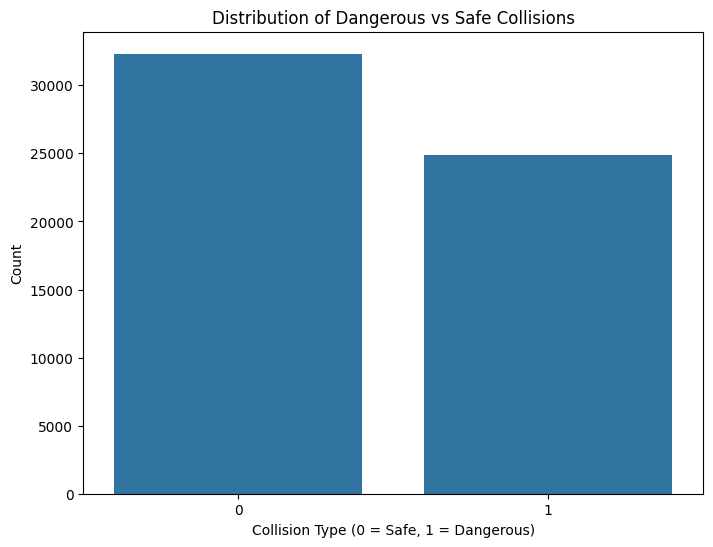

In [13]:
# Plot Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='dangerous', data=df)
plt.title('Distribution of Dangerous vs Safe Collisions')
plt.xlabel('Collision Type (0 = Safe, 1 = Dangerous)')
plt.ylabel('Count')
plt.show()

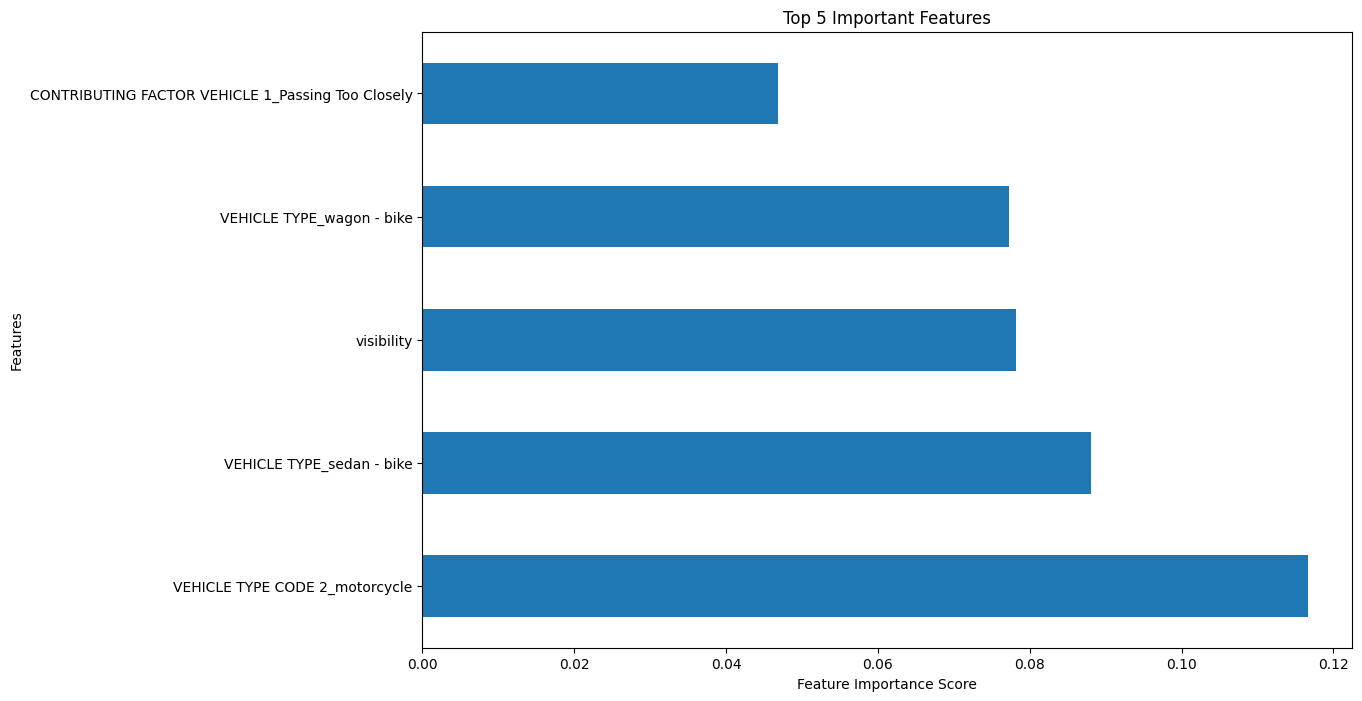

In [14]:
# Plot Feature Importance
importances = best_model.feature_importances_
feature_names = df.drop(columns=['dangerous']).columns
feature_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(12, 8))
feature_importances.nlargest(5).plot(kind='barh')
plt.title('Top 5 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

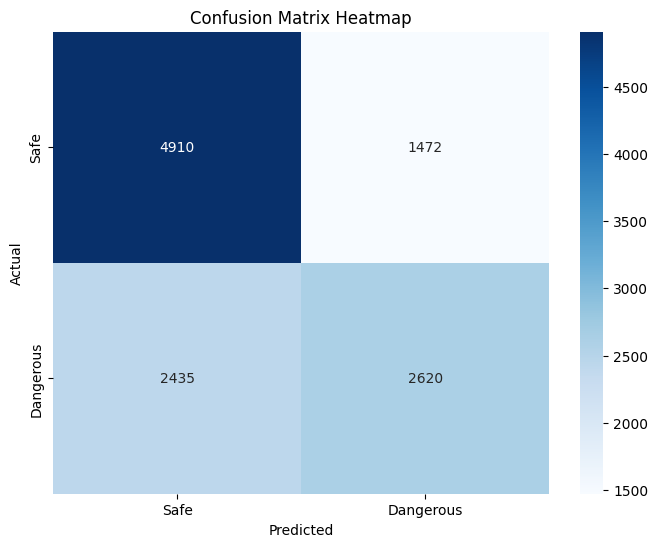

In [15]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Dangerous'], yticklabels=['Safe', 'Dangerous'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
# Dangerous collisions by precipitation type
if 'preciptype' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='preciptype', hue='dangerous', data=df)
    plt.title('Dangerous vs Safe Collisions by Precipitation Type')
    plt.xlabel('Precipitation Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

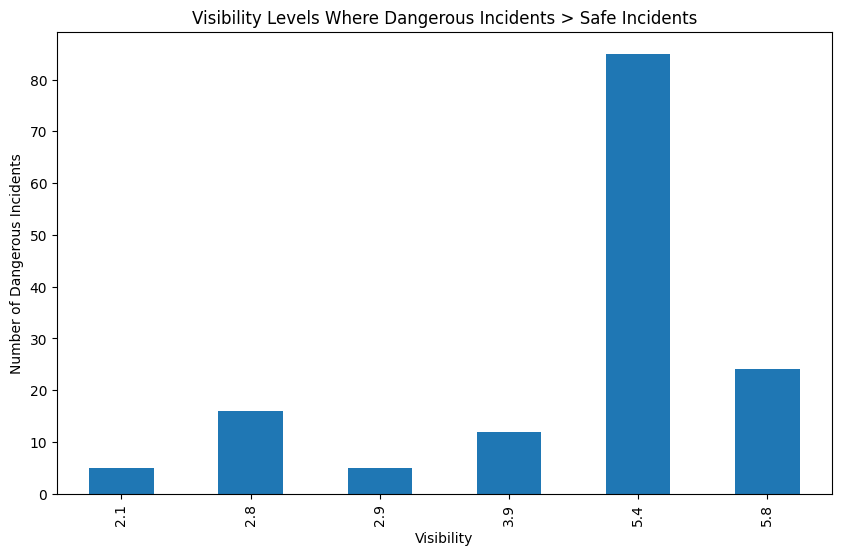

In [20]:
# Visibility where dangerous incidents > safe incidents
if 'visibility' in df.columns:
    visibility_grouped = df.groupby('visibility')['dangerous'].value_counts().unstack().fillna(0)
    visibility_dangerous = visibility_grouped[1]  # Dangerous collisions
    visibility_safe = visibility_grouped[0]       # Safe collisions

    # Filter where dangerous incidents > safe incidents
    dangerous_more_than_safe = visibility_dangerous[visibility_dangerous > visibility_safe]

    plt.figure(figsize=(10, 6))
    dangerous_more_than_safe.plot(kind='bar')
    plt.title('Visibility Levels Where Dangerous Incidents > Safe Incidents')
    plt.xlabel('Visibility')
    plt.ylabel('Number of Dangerous Incidents')
    plt.show()

<Figure size 1400x800 with 0 Axes>

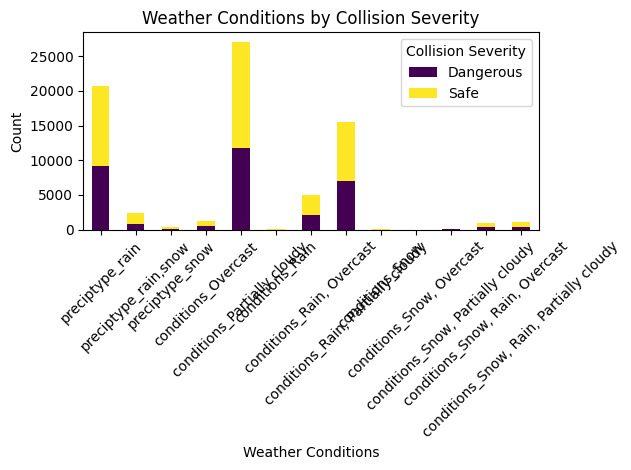

In [21]:
# Compare one-hot encoded weather conditions by severity
weather_columns = [col for col in df.columns if 'conditions_' in col or 'preciptype_' in col]

# Create a DataFrame to store aggregated counts for dangerous and safe collisions
weather_summary = []

for col in weather_columns:
    dangerous_count = df[df['dangerous'] == 1][col].sum()
    safe_count = df[df['dangerous'] == 0][col].sum()
    weather_summary.append({'Condition': col, 'Dangerous': dangerous_count, 'Safe': safe_count})

# Convert to a DataFrame
weather_summary_df = pd.DataFrame(weather_summary)

# Plot the results
plt.figure(figsize=(14, 8))
weather_summary_df.set_index('Condition')[['Dangerous', 'Safe']].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Weather Conditions by Collision Severity')
plt.xlabel('Weather Conditions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Collision Severity')
plt.tight_layout()
plt.show()